In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
pd.set_option('display.max_rows', 500)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import time
import math
pd.options.mode.copy_on_write = True 
import datetime

In [2]:
df_lane = pd.read_excel(r'C:\Users\C385490\OneDrive - Anheuser-Busch InBev\Projects\Shipment_Prediction\Data\Lane_shipment_data.xlsx')
df_lane.head()

,date,week,year,month,Lane,shipment
0,2021-12-20,51,2021,12,DE02_29080846,1
1,2022-03-21,12,2022,3,DE02_29080846,1
2,2020-01-06,2,2020,1,DE02_29080846,0
3,2020-01-13,3,2020,1,DE02_29080846,0
4,2020-01-20,4,2020,1,DE02_29080846,0


In [3]:
df_holiday = pd.read_excel(r'C:\Users\C385490\OneDrive - Anheuser-Busch InBev\Projects\Shipment_Prediction\Data\holiday sheet.xlsx')
df_holiday.head()

,year,week,Holiday Flag
0,2020,1,1
1,2020,15,1
2,2020,17,1
3,2020,18,1
4,2020,21,1


In [4]:
df_holiday.dtypes

year            int64
week            int64
Holiday Flag    int64
dtype: object

# Data Preprocessing

In [5]:

def top20Lane_selection(final_data):
    week_count = pd.DataFrame(columns = ['Lane','Count'])
    lan = []
    count = []

    top_lanes= final_data[(final_data['year']==2023) & final_data['shipment']!=0]
    for lane in top_lanes['Lane'].unique():
        cnt = top_lanes[top_lanes['Lane']==lane]['date'].nunique()
        lan.append(lane)
        count.append(cnt)

    week_count['Lane'] = lan
    week_count['Count'] = count

    lanes_week_wise = list(week_count.sort_values('Count', ascending = False)[:30]['Lane'].unique())

    top20_Lanes = final_data[final_data['Lane'].isin(lanes_week_wise)].reset_index(drop=True)
    top20_Lanes = top20_Lanes.groupby(['Lane','year'])['shipment'].sum().reset_index()
    top20_Lanes = top20_Lanes[top20_Lanes['year']==2023]
    top20_Lanes = list(top20_Lanes.sort_values('shipment', ascending = False)[:20]['Lane'].unique())

    top20_df = final_data[final_data['Lane'].isin(top20_Lanes)].reset_index(drop=True)


    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Fit and transform the categorical column
    encoded_values = label_encoder.fit_transform(top20_df['Lane'])

    ## Create a dictionary to store the mapping of original labels to encoded values
    label_mapping = {label: int(encoded_value) for label, encoded_value in zip(label_encoder.classes_, encoded_values)}

    # Save the label mapping as JSON file
    with open('lane_enocoded_labels.json', 'w') as json_file:
        json.dump(label_mapping, json_file)

    # read the label mapping JSON file
    with open('lane_enocoded_labels.json', 'r') as json_file:
        label_mapping = json.load(json_file)

    
    top20_df['Encoded_Lane'] = top20_df['Lane'].map(label_mapping)

    return top20_df


    

In [6]:
def data_manipulation_selection(df_lane,df_holiday):
    final_data = pd.merge(df_lane, df_holiday, on=['year', 'week'], how='left')
    #fill Nan value with 0 in holiday_flag
    final_data['Holiday Flag'] = final_data['Holiday Flag'].fillna(0)
    final_data['Holiday Flag'] = final_data['Holiday Flag'].astype(np.int64)


    final_data['Quarter'] = final_data['date'].dt.quarter
    final_data['Quarter'] = final_data['Quarter'].astype(np.int64)

    top20_df = top20Lane_selection(final_data)

    return final_data, top20_df

    

In [7]:
final_data, top20_df = data_manipulation_selection(df_lane,df_holiday)
top20_df.shape

(4160, 9)

In [8]:
from scipy.special import boxcox, inv_boxcox

def data_tain_test_split(top20_df):

    # Box-cox transform
    top20_df['shipment_transformed']= np.log1p(top20_df['shipment'])
    


    #filter latest 8 weeks for testing the model
    test = top20_df[(top20_df['year'] == 2023) & (top20_df['week'] >= 45)].reset_index(drop=True)
    #train dataset except last 8 weeks
    train = top20_df.drop(index = test.index.tolist()).reset_index(drop=True)
    

    return train, test

In [9]:
train, test = data_tain_test_split(top20_df)
print("train_data_shape: ",train.shape)
print("test_data_shape: ",test.shape)

train_data_shape:  (4000, 10)
test_data_shape:  (160, 10)


In [10]:
def data_preprocessing(df):

    # 1st Lag features
    df['Previous Week Shipment'] = df['shipment'].shift(1)
    df['Previous Year Shipment'] = df.groupby(['Lane'])['shipment'].shift(52)

    # 2nd Lag features
    df['Previous 2Week Shipment'] = df['shipment'].shift(2)
    

    #Filling Nan values in 1st Lag Feature

    df['Previous Year Shipment'] = df['Previous Year Shipment'].interpolate()
    df['Previous Year Shipment'] = df['Previous Year Shipment'].fillna(0)
    df['Previous Week Shipment'] = df['Previous Week Shipment'].fillna(0)
    df['Previous 2Week Shipment'] = df['Previous 2Week Shipment'].fillna(0)
    
    
    # Historical trends
    df['Moving Average Shipment'] = df.groupby(['Lane'])['shipment'].rolling(window=4).mean().reset_index(drop=True)
    df['Moving Average Shipment'] = df['Moving Average Shipment'].fillna(0) 

    # Convert created features to integer
    df['Previous Week Shipment'] = df['Previous Week Shipment'].astype(np.int64)
    df['Previous 2Week Shipment'] = df['Previous 2Week Shipment'].astype(np.int64)
    df['Previous Year Shipment'] = df['Previous Year Shipment'].astype(np.int64)
    df['Moving Average Shipment'] = df['Moving Average Shipment'].astype(np.int64)

    X = df.drop(columns = ['date', 'year', 'Lane',  'Quarter','shipment', 'shipment_transformed'])
    y = df['shipment_transformed']

    return df, X, y
    
    

In [11]:
training_data, X_train, y_train = data_preprocessing(train)
print("X_train_shape: ",X_train.shape)
print("y_train_shape: ",y_train.shape)

X_train_shape:  (4000, 8)
y_train_shape:  (4000,)


(array([ 572.,    0., 1426.,  868.,  448.,  370.,  222.,   59.,   29.,
           6.]),
 array([0.        , 0.32188758, 0.64377516, 0.96566275, 1.28755033,
        1.60943791, 1.93132549, 2.25321308, 2.57510066, 2.89698824,
        3.21887582]),
 <BarContainer object of 10 artists>)

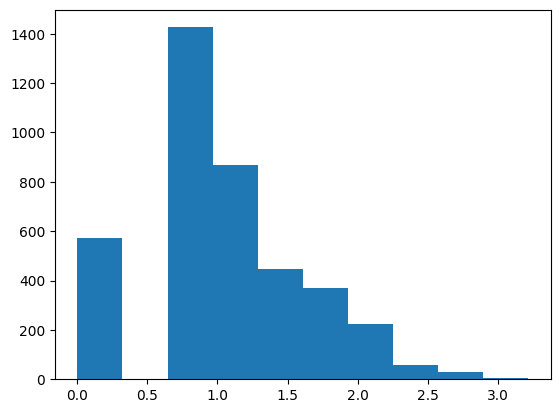

In [12]:
import matplotlib.pyplot as plt
plt.hist(y_train)

# Model Building

In [13]:
import xgboost as xgb 

def XGB_model(X_train, y_train):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    return model

In [15]:
def model_training(model, X_train, y_train):
    if model == 'xgboost':
        model_xgb = XGB_model(X_train, y_train)

    return model_xgb

In [16]:
model_xgb = model_training('xgboost', X_train, y_train)

# Prediction

In [17]:
# Sample function to calculate WAPE
def weighted_absolute_percentage_error(y_true, y_pred):
    total_weight = sum(y_true)
    
    # Check if total_weight is zero to avoid division by zero
    if total_weight == 0:
        return None  # Return None to indicate no shipments
    
    absolute_errors = abs(y_true - y_pred)
    weighted_absolute_errors = absolute_errors * y_true
    wape = sum(weighted_absolute_errors) / total_weight * 100
    return wape

In [18]:
test_data, X_test, y_test = data_preprocessing(test)
print("X_test_shape: ",X_test.shape)
print("y_test_shape: ",y_test.shape)


X_test_shape:  (160, 8)
y_test_shape:  (160,)


In [19]:

def predict_evaluate(model, X_test, y_test):
    # Predict
    y_pred = model.predict(X_test)
    #y_pred = np.expm1(y_pred)
        
    # Calculate WAPE score
    wape = weighted_absolute_percentage_error(y_test, y_pred)


    test['Predicted_shipment'] = [round(np.expm1(x)) for x in y_pred]
    #test['Predicted_shipment'] = [round(x) for x in y_pred]
    
    
    return test, wape
    

In [20]:
y_train.isna().sum()

0

In [22]:
predicted_df, wape = predict_evaluate(model_xgb, X_test, y_test)
wape

43.98938200411061

In [23]:
predicted_df.to_csv('predicted_shipment_V8.csv', index = False)

(array([13., 74.,  0., 60.,  0.,  8.,  3.,  0.,  1.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

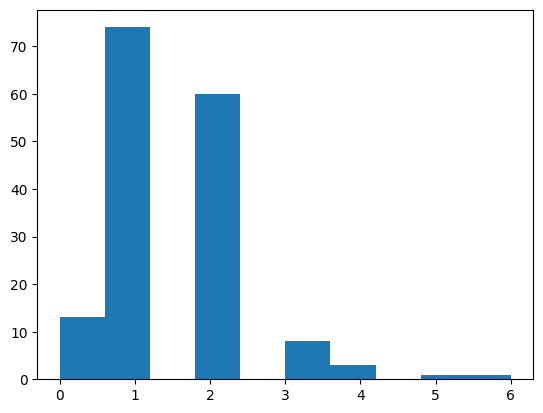

In [24]:
plt.hist(predicted_df['Predicted_shipment'])

In [25]:
predicted_df['Predicted_shipment'].unique()

array([2, 4, 3, 1, 5, 6, 0], dtype=int64)

In [26]:
predicted_df['shipment'].unique()

array([ 4,  3,  6,  2,  5,  7,  1,  9,  0,  8, 12], dtype=int64)

In [27]:
#predicted_df[predicted_df['Predicted_shipment']>2][['shipment', 'Predicted_shipment']]
predicted_df[['shipment', 'Predicted_shipment']].head(10)

,shipment,Predicted_shipment
0,4,2
1,3,4
2,6,3
3,2,1
4,5,5
5,3,2
6,7,6
7,2,2
8,3,2
9,6,3


In [28]:
import joblib
# Save the model to a file
joblib.dump(model_xgb, 'cat_model_V8.joblib')

['cat_model_V8.joblib']

In [29]:
100 - wape

56.01061799588939